<a href="https://colab.research.google.com/github/peeyushsinghal/EVA/blob/main/S5-Assignment%20Solution/EVA_S5_Exp4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Libraries

In [1]:
import torch
from torchvision import datasets,transforms
%matplotlib inline
import matplotlib.pyplot as plt # for visualizing images
import random # for random image index
import torch.nn as nn # for network
import torch.nn.functional as F # for forward method
import torch.optim as optim # for optimizer
!pip install torchsummary
from torchsummary import summary # for model summary and params
from tqdm import tqdm # for beautiful model training updates

Seed and Cuda

In [2]:
# check for cuda
cuda = torch.cuda.is_available()
print (f' Cuda Status : {cuda}')

# setting seed
SEED = 42 # arbit seed, why 42 - because in hitch hikers guide to galaxy it is answer to everything
# torch.cuda.seed(SEED) 
torch.cuda.manual_seed_all(SEED) if cuda else torch.manual_seed(SEED)

 Cuda Status : True


### Downloading dataset, splitting datasets
loading dataset

In [3]:
train = datasets.MNIST(
    root = './',# directory where data needs to be stored
    train = True, # get the training portion of the dataset
    download = True, # downloads
    transform = transforms.Compose([
                  transforms.RandomRotation((-7.0, 7.0), fill=(1,)), #random rotation
                  transforms.ToTensor(),# converts to tesnor
                  transforms.Normalize((0.1307,), (0.3081,))# Normalize
                ])
    )

test = datasets.MNIST(
    root = './',# directory where data needs to be stored
    train = False, # get the test portion of the dataset
    download = True, # downloads
    transform = transforms.Compose([
                  transforms.ToTensor(),# converts to tesnor
                  transforms.Normalize((0.1307,), (0.3081,))# Normalize
                ])
    )

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Train and Test Dataloader

In [4]:
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory = True) if cuda else dict(shuffle=True, batch_size=64)

train_loader = torch.utils.data.DataLoader(
    dataset=train,# train dataset
    **dataloader_args # the dataloader arguments change dependent on cuda is available or not
    )

test_loader = torch.utils.data.DataLoader(
    dataset = test,# test dataset 
    **dataloader_args # the dataloader arguments change dependent on cuda is available or not
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Checking Dataloaders
- sample data

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 1, 28, 28])
torch.Size([128])


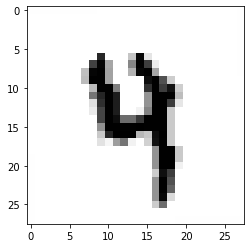

In [5]:
images, labels  = next(iter(train_loader))
print(images.shape)
print(labels.shape)
# printing random image and seeing
plt.imshow(images[random.randint(0,len(images))].numpy().squeeze(), cmap='gray_r')

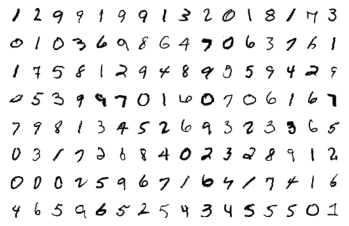

In [6]:
# Looking at more images
figure = plt.figure()
for index in range(1, len(images) + 1): # assumption: batch size would be atleast 8
    plt.subplot(8, int(len(images)/8), index)
    plt.axis('off')
    plt.imshow(images[index-1].numpy().squeeze(), cmap='gray_r')

### Network

In [7]:
class Network(nn.Module):
  def __init__(self):
    super(Network,self).__init__() # extending super class method
    
    drop_out_value = 0.1

    # Input Block
    self.convblock1 = nn.Sequential(
        nn.Conv2d(1,10,3), # In- 1x28x28, Out- 16x26x26, RF- 3x3, Jump_in -1, Jump_out -1
        nn.ReLU(),
        nn.BatchNorm2d(10),
        nn.Dropout(drop_out_value)
    ) 

    # Conv Block 2
    self.convblock2 = nn.Sequential(
        nn.Conv2d(10,10,3), # In- 16x26x26, Out- 16x24x24, RF- 5x5, Jump_in -1, Jump_out -1
        nn.ReLU(),
        nn.BatchNorm2d(10),
        nn.Dropout(drop_out_value)
    ) 

    # Conv Block 3
    self.convblock3 = nn.Sequential(
        nn.Conv2d(10,10,3), # In- 16x24x24, Out- 16x22x22, RF- 7x7, Jump_in -1, Jump_out -1
        nn.ReLU(),
        nn.BatchNorm2d(10),
        nn.Dropout(drop_out_value)
    ) 

    self.convblock3_1 = nn.Sequential(
        nn.Conv2d(10,10,3), # In- 16x22x22, Out- 16x20x20, RF- 7x7, Jump_in -1, Jump_out -1
        nn.ReLU(),
        nn.BatchNorm2d(10),
        nn.Dropout(drop_out_value)
    ) 

    #### Transition Block 1 (this also includes a conv block)
    
    # self.convblock4 = nn.Sequential(
    #     nn.Conv2d(16,10,1), # In- 16x22x22, Out- 10x22x22, RF- 7x7, Jump_in -2, Jump_out -2
    #     nn.ReLU(),
    #     nn.BatchNorm2d(10),
    #     nn.Dropout(drop_out_value)
    # )
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # In- 16x20x20, Out- 16x10x10, RF- 8x8, Jump_in -1, Jump_out -2
    # self.convblock4 = nn.Sequential(
    #     nn.Conv2d(10,10,1), # In- 16x10x10, Out- 16x10x10, RF- 8x8, Jump_in -2, Jump_out -2
    #     nn.ReLU(),
    #     nn.BatchNorm2d(10),
    #     nn.Dropout(drop_out_value)
    # ) 

    # Conv Block 5
    self.convblock5 = nn.Sequential(
        nn.Conv2d(10,20,3), # In- 8x11x11, 10x10x10, Out- 16x9x9, 20x8x8, RF- 12x12, Jump_in -2, Jump_out -2
        nn.ReLU(),
        nn.BatchNorm2d(20),
        nn.Dropout(drop_out_value)
    ) 

    # Conv Block 6
    self.convblock6 = nn.Sequential(
        nn.Conv2d(20,20,3), # In- 16x9x9,20x8x8, Out- 16x7x7,20x6x6, RF- 16x16, Jump_in -2, Jump_out -2
        nn.ReLU(),
        nn.BatchNorm2d(20),
        nn.Dropout(drop_out_value)
    ) 

    # Output Block
    self.convblock7 = nn.Sequential(
        nn.Conv2d(20,10,1), # In- 16x7x7,20x6x6, Out- 10x7x7,10x6x6, RF- 16x16, Jump_in -2, Jump_out -2
        nn.ReLU(),
        nn.BatchNorm2d(10),
        nn.Dropout(drop_out_value)
    ) 

    self.gap = nn.AvgPool2d(6) # In- 10x7x7, Out- 10x1x1, RF- 16x16, Jump_in -2, Jump_out -2

  
  def forward(self,x):

    x = self.convblock1(x)
    x = self.convblock2(x)
    x = self.convblock3(x)
    x= self.convblock3_1(x)

    # x = self.convblock4(x)
    x = self.pool1(x)
    # x = self.convblock4(x)
    x = self.convblock5(x)
    x = self.convblock6(x)

    x = self.convblock7(x)
    x = self.gap(x)

    # Flattening
    x = x.view(-1,10)
    return F.log_softmax(x,dim=-1)

# model = Network()
# print(model)

### Model Params
  - Checking the model summary and number of parameters

In [8]:
device = torch.device("cuda" if cuda else "cpu")
print(device)
model = Network().to(device)
# print(model)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             910
              ReLU-6           [-1, 10, 24, 24]               0
       BatchNorm2d-7           [-1, 10, 24, 24]              20
           Dropout-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 10, 22, 22]             910
             ReLU-10           [-1, 10, 22, 22]               0
      BatchNorm2d-11           [-1, 10, 22, 22]              20
          Dropout-12           [-1, 10, 22, 22]               0
           Conv2d-13           [-1, 10, 20, 20]             910
             ReLU-14           [-1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


### Training and Testing
- includes test and train functions
- includes loop function, where test can happen after each epoch is trained


In [9]:
# Training Function
train_losses = [] # to capture train losses over training epochs
train_accuracy = [] # to capture train accuracy over training epochs

def train(model,device, train_loader,optimizer,epoch):
  model.train() # setting the model in training mode
  pbar = tqdm(train_loader) # putting the iterator in pbar
  correct = 0 # for accuracy numerator
  processed =0 # for accuracy denominator

  for batch_idx, (images,labels) in enumerate(pbar):
    images, labels = images.to(device),labels.to(device)#sending data to CPU or GPU as per device
    optimizer.zero_grad() # setting gradients to zero to avoid accumulation

    y_preds = model(images) # forward pass, result captured in y_preds (plural as there are many images in a batch)
    # the predictions are in one hot vector

    loss = F.nll_loss(y_preds,labels) # capturing loss
    train_losses.append(loss) # to capture loss over many epochs

    loss.backward() # backpropagation
    optimizer.step() # updating the params

    preds = y_preds.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += preds.eq(labels.view_as(preds)).sum().item()
    processed += len(images)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_accuracy.append(100*correct/processed)


In [10]:
# Test Function
test_losses = [] # to capture test losses 
test_accuracy = [] # to capture test accuracy 

def test(model,device, test_loader):
  model.eval() # setting the model in evaluation mode
  test_loss = 0
  correct = 0 # for accuracy numerator

  with torch.no_grad():
    for (images,labels) in test_loader:
      images, labels = images.to(device),labels.to(device)#sending data to CPU or GPU as per device
      outputs = model(images) # forward pass, result captured in outputs (plural as there are many images in a batch)
      # the outputs are in batch size x one hot vector 

      test_loss = F.nll_loss(outputs,labels, reduction='sum').item()  # sum up batch loss
      preds = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += preds.eq(labels.view_as(preds)).sum().item()

    test_loss /= len(test_loader.dataset) # average test loss
    test_losses.append(test_loss) # to capture loss over many batches

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

    test_accuracy.append(100*correct/len(test_loader.dataset))


In [11]:
model =  Network().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

# EPOCHS = 1
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.19718711078166962 Batch_id=468 Accuracy=86.98: 100%|██████████| 469/469 [00:26<00:00, 17.81it/s]



Test set: Average loss: 0.0002, Accuracy: 9546/10000 (95.46%)

EPOCH: 1


Loss=0.16666346788406372 Batch_id=468 Accuracy=96.75: 100%|██████████| 469/469 [00:26<00:00, 17.83it/s]



Test set: Average loss: 0.0001, Accuracy: 9766/10000 (97.66%)

EPOCH: 2


Loss=0.10558459907770157 Batch_id=468 Accuracy=97.29: 100%|██████████| 469/469 [00:26<00:00, 17.72it/s]



Test set: Average loss: 0.0001, Accuracy: 9763/10000 (97.63%)

EPOCH: 3


Loss=0.07202073186635971 Batch_id=468 Accuracy=97.68: 100%|██████████| 469/469 [00:26<00:00, 17.74it/s]



Test set: Average loss: 0.0003, Accuracy: 9829/10000 (98.29%)

EPOCH: 4


Loss=0.055123865604400635 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:26<00:00, 17.73it/s]



Test set: Average loss: 0.0001, Accuracy: 9855/10000 (98.55%)

EPOCH: 5


Loss=0.152736634016037 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:26<00:00, 17.85it/s]



Test set: Average loss: 0.0000, Accuracy: 9863/10000 (98.63%)

EPOCH: 6


Loss=0.051460836082696915 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:26<00:00, 17.96it/s]



Test set: Average loss: 0.0001, Accuracy: 9885/10000 (98.85%)

EPOCH: 7


Loss=0.07457531988620758 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:26<00:00, 17.54it/s]



Test set: Average loss: 0.0000, Accuracy: 9863/10000 (98.63%)

EPOCH: 8


Loss=0.06236036494374275 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:26<00:00, 17.49it/s]



Test set: Average loss: 0.0000, Accuracy: 9887/10000 (98.87%)

EPOCH: 9


Loss=0.04667657986283302 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:26<00:00, 17.46it/s]



Test set: Average loss: 0.0004, Accuracy: 9889/10000 (98.89%)

EPOCH: 10


Loss=0.06606817990541458 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:26<00:00, 17.62it/s]



Test set: Average loss: 0.0000, Accuracy: 9912/10000 (99.12%)

EPOCH: 11


Loss=0.04824667051434517 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:26<00:00, 17.54it/s]



Test set: Average loss: 0.0000, Accuracy: 9916/10000 (99.16%)

EPOCH: 12


Loss=0.02981693483889103 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:26<00:00, 17.48it/s]



Test set: Average loss: 0.0000, Accuracy: 9902/10000 (99.02%)

EPOCH: 13


Loss=0.03252105042338371 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:26<00:00, 17.42it/s]



Test set: Average loss: 0.0001, Accuracy: 9905/10000 (99.05%)

EPOCH: 14


Loss=0.062187906354665756 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:26<00:00, 17.57it/s]



Test set: Average loss: 0.0000, Accuracy: 9925/10000 (99.25%)



Text(0.5, 1.0, 'Test Accuracy')

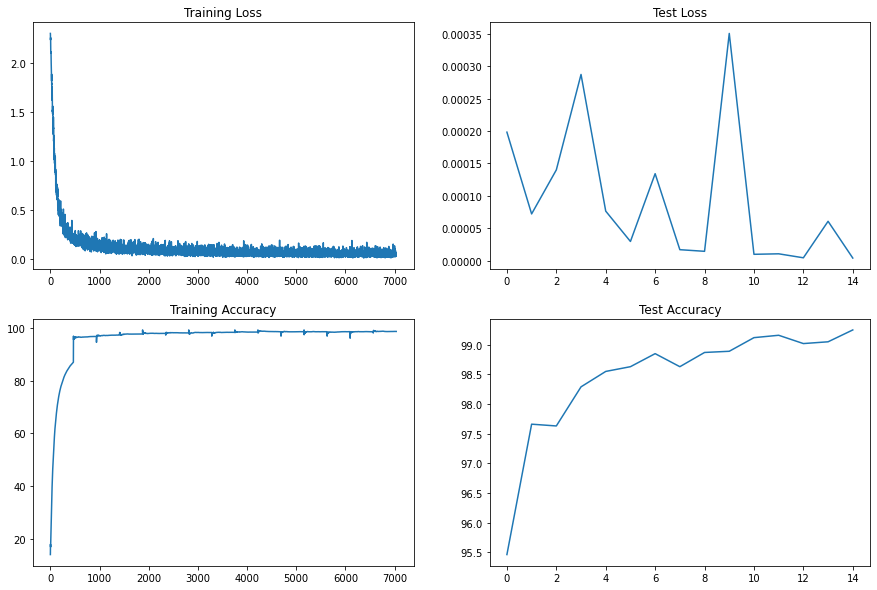

In [12]:
# Graphs
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_accuracy)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_accuracy)
axs[1, 1].set_title("Test Accuracy")

### Conclusion
Experiment Number	: 4

Objective / Target	
1. increase accuracy by increasing number of params
2. include augmentation
3. step learning rate


Results	
- Parameters: 8,660
- Best Train Accuracy: 98.65%
- Best Test Accuracy: 99.25%

Analysis	
1. Not hitting the accuracy mark
2. Overfitting (train - test accuracy) < 0 is largely containted
3. Number of params < 10K

Next Steps	
- Look to increase accuracy 